## 양선옥 교수님의 수업 과제
임베딩모델과 벡터DB의 소개 및 종류 별 성능 분석

### langchain을 이용한 RAG 시스템에서의 성능 분석

#### 데이터 불러오기

In [2]:
import os
import json
from glob import glob
from pathlib import Path
from langchain_core.documents import Document
from tqdm import tqdm

In [22]:
max_len = 4000

medical_src_data_dir = "C:/dataset/08.전문 의학지식 데이터/3.개방데이터/1.데이터/Training/raw_data"
medical_src_data = list()
medical_src_data_path = glob(os.path.join(medical_src_data_dir, "*.json"))
for file_path in tqdm(medical_src_data_path, desc="Loading medical source data"):
    with open(file_path, "r", encoding="utf-8-sig") as f:
        data = json.load(f)
        if len(data["content"]) > max_len:
            continue
        doc = Document(
            page_content=data["content"], 
            metadata={
                "source": data["source"], 
                "domain": data["domain"],
                "source": data["source"],
                "source_spec": data["source_spec"],
                "creation_year": data["creation_year"],
            })
        medical_src_data.append(doc)

Loading medical source data: 100%|██████████| 159/159 [00:00<00:00, 10345.54it/s]


In [4]:
medical_data_dir = "C:/dataset/08.전문 의학지식 데이터/3.개방데이터/1.데이터/Training/02.라벨링데이터/"
# medical_data_class_path = [Path(path) for path in glob(os.path.join(medical_data_dir, "TL_기타/"))]
medical_label_data = list()
for class_path in medical_data_class_path:
    class_path_list = list(class_path.glob("*.json"))[:30]
    for file_path in tqdm(class_path_list, desc=f"Loading {class_path.name}"):
        with open(file_path, "r", encoding="utf-8-sig") as f:
            data = json.load(f)
            if len(data["question"]) > max_len:
                continue
            doc = Document(
                page_content=data["question"], 
                metadata={
                    "answer": data["answer"], 
                    "domain": data["domain"],
                    "q_type": data["q_type"],
                })
            medical_label_data.append(doc)

Loading TL_기타: 100%|██████████| 30/30 [00:00<00:00, 10985.61it/s]


In [21]:
PPP = [Path(path) for path in glob(os.path.join(medical_data_dir, "*/"))]
sum([len(list(path.glob("*.json",))) for path in PPP])    

12228

In [35]:
medical_label_data[0], medical_src_data[0]

(Document(metadata={'answer': '이 환자의 초기 치료는 비수술적 방법을 우선으로 한다. 비스테로이드성 소염제(NSAIDs)와 근육 이완제를 사용하여 통증을 완화하고, 물리치료를 통해 허리 근육을 강화하며 자세를 교정한다. 또한, 생활습관 개선이 중요하며, 올바른 자세 유지와 체중 조절을 권장한다. 대부분의 경우 이러한 비수술적 치료로 증상이 호전되지만, 증상이 지속되거나 악화될 경우에는 수술적 치료를 고려할 수 있다.', 'domain': 13, 'q_type': 3}, page_content='60세 남성이 만성 요통과 다리 저림을 호소하며 내원했다. MRI에서 요추 추간판 탈출증이 확인되었다. 이 환자의 초기 치료 방침을 설명하시오.'),
 Document(metadata={'source': 6, 'domain': 1, 'source_spec': 'Harrison-21', 'creation_year': '2023'}, page_content="RAS 단백질이 활성화되면, 이어서 RAF, MEK, ERK와 같은 키나제의 계단식 반응이 유도됩니다. 마지막으로 활성화된 ERK는 핵으로 이동하여 세포 분열과 생존에 필요한 유전자 발현을 조절하는 전사 인자를 활성화합니다. 이 경로의 과활성화는 암 발생에 중요한 역할을 하며, RAS나 BRAF의 돌연변이는 여러 유형의 암에서 흔히 발견됩니다. PI3K-AKT-mTOR 경로는 세포 생존, 성장, 그리고 대사 조절에 중요한 역할을 합니다. RTK의 활성화는 PI3K를 활성화시키고, 이어서 AKT와 mTOR을 활성화하여 세포 성장과 생존을 촉진합니다. 이 경로는 또한 세포 자멸사를 억제하여 암세포가 더 오래 생존하도록 돕습니다. PI3K, AKT, mTOR의 돌연변이나 과발현은 다양한 암에서 발견되며, 이 경로를 표적으로 하는 치료제들이 개발되고 있습니다. PLC-γ 경로에서 RTK의 활성화는 PLC-γ를 활성화시키고, 이는 막 지질인 PIP2를 DAG와 IP3로 분해하여 다양한 세포 내 신호 전달

#### 임베딩 모델 설정

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

openai_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
google_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
ko_embeddings = HuggingFaceEmbeddings(model_name="dragonkue/snowflake-arctic-embed-l-v2.0-ko")

In [7]:
query = "hello"
len(openai_embeddings.embed_query(query)), len(google_embeddings.embed_query(query)), len(ko_embeddings.embed_query(query))

1024

#### 벡터DB 설정

In [5]:
from dotenv import load_dotenv
load_dotenv()

from langchain_community.vectorstores import FAISS
from langchain_chroma import Chroma
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_pinecone import PineconeVectorStore
import torch

In [6]:
openai_vectorstore_dict = dict()

batch_size = 10

chroma_db = Chroma(
    embedding_function=openai_embeddings,
    persist_directory="C:/dataset/08.전문 의학지식 데이터/3.개방데이터/1.데이터/Training/hug_split_chroma_db_noid",
    collection_name="medical_src_data"
)

for i in range(0, len(medical_src_data), batch_size):
    chroma_db.add_documents(medical_src_data[i:i+batch_size])

openai_vectorstore_dict["chroma"] = chroma_db.as_retriever()

In [10]:
client = QdrantClient(path="C:/dataset/08.전문 의학지식 데이터/3.개방데이터/1.데이터/Training/hug_split_qdrant_noid")

client.create_collection(
    collection_name="medical_src_data",
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE),
)

qdrant_db = QdrantVectorStore(
    client=client,
    collection_name="medical_src_data",
    embedding=openai_embeddings,
)

for i in range(0, len(medical_src_data), batch_size):
    qdrant_db.add_documents(medical_src_data[i:i+batch_size])
    torch.cuda.empty_cache()

openai_vectorstore_dict["qdrant"] = qdrant_db.as_retriever()

In [12]:
pinecone_db = PineconeVectorStore(
    index_name="medical-src-data-hug",
    embedding=openai_embeddings,
)

for i in range(0, len(medical_src_data), batch_size):
    pinecone_db.add_documents(medical_src_data[i:i+batch_size])
    torch.cuda.empty_cache()

openai_vectorstore_dict["pinecone"] = pinecone_db.as_retriever()

In [13]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore

faiss_db = FAISS(
    embedding_function=openai_embeddings,
    index=faiss.IndexFlatL2(1024),
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)
for i in range(0, len(medical_src_data), batch_size):
    faiss_db.add_documents(medical_src_data[i:i+batch_size])
    torch.cuda.empty_cache()

openai_vectorstore_dict["faiss"] = faiss_db.as_retriever()
faiss_db.save_local(folder_path="C:/dataset/split_faiss_hug", index_name="medical_src_data")

In [51]:
openai_vectorstore_dict["chroma"].invoke("당뇨")

[Document(id='6bd1739f-9c72-4a81-840f-efcf9b1b91b9', metadata={'domain': 1, 'source_spec': "['5375)', 'docx']", 'creation_year': '2023', 'source': 6}, page_content='당뇨병은 전 세계적으로 가장 심각한 공중 보건 문제 중 하나로, 그 영향력과 경제적 부담은 해마다 증가하고 있습니다. 단순히 혈당 조절의 문제가 아니라, 복잡한 대사 장애로 정의되며, 다양한 기전과 합병증을 통해 환자의 전반적인 건강에 광범위하게 영향을 미칩니다. 특히 심혈관계, 신장, 신경계, 시각계에 치명적인 영향을 미치며, 환자의 삶의 질을 심각하게 저하시키는 만성 질환입니다. 본 논의에서는 당뇨병의 병태생리학, 유병률, 합병증, 최신 치료 전략에 대해 심도 있게 다룹니다. 1형 당뇨병은 자가면역 반응으로 인해 췌장의 베타 세포가 파괴되는 것이 특징입니다. 유전적 소인(HLA 유전자 등)과 환경적 요인이 결합하여 자가면역 반응을 유발하며, 자가항체(항-GAD65 항체, 항-ICA 항체 등)가 베타 세포를 공격합니다. T 세포, 특히 CD8+ 세포는 베타 세포 표면의 항원을 인식하여 이를 제거하며, 이로 인해 인슐린 분비가 급격히 감소합니다. 환자는 생명을 유지하기 위해 외부에서 인슐린을 공급받아야 합니다. 최근 연구에서는 Th17 세포와 같은 새로운 면역 세포가 자가면역 반응의 중추적 역할을 한다는 증거가 보고되고 있으며, 이는 면역 조절제나 백신 개발의 기초 자료로 활용될 수 있습니다. 2형 당뇨병은 인슐린 저항성과 췌장의 베타 세포 기능 저하가 결합된 결과로 발생합니다. 인슐린 저항성은 인슐린 수용체 신호 전달 경로의 결함에서 비롯되며, 말초 조직에서의 포도당 흡수가 저하됩니다. 초기에는 베타 세포가 인슐린 분비를 증가시켜 이를 보상하려 하지만, 시간이 지남에 따라 베타 세포의 기능이 저하되고, 결국 인슐린 분비가 감소하여 고혈당이 만성화됩니다. 유리 지방산과 

#### Naive RAG 설정

In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

#Question: 
{question} 
#Context: 
{context} 

#Answer:"""
)

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

openai_chain_dict = dict()
for vector_store_name in openai_vectorstore_dict.keys():
    openai_chain_dict[vector_store_name] = (
        {"context": openai_vectorstore_dict[vector_store_name], "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

In [63]:
test_query = "다음 중 가족 중심 중재(Family-Centered Intervention)에 대한 설명으로 옳은 것은?  \n1) 가족 중심 중재는 모든 환자에서 동일한 효과를 보인다.  \n2) 가족 중심 중재는 부작용이 자주 발생한다.  \n3) 가족 중심 중재는 환자와 가족의 전반적인 건강과 복지를 향상시킬 가능성이 있다.  \n4) 가족 중심 중재는 신체 건강만을 개선하는 데 초점이 맞춰져 있다.  \n5) 가족 중심 중재는 연구에서 항상 비뚤림 위험이 없는 것으로 나타났다."

In [64]:
print(llm.invoke(test_query).content)

정답은 3)입니다.

가족 중심 중재는 환자와 가족의 참여를 강조하여, 환자의 치료 및 관리에 가족을 적극적으로 참여시키는 접근 방식입니다.  이를 통해 환자의 전반적인 건강(신체적, 정신적, 사회적)과 가족의 복지 향상을 목표로 합니다.

다른 보기들은 모두 옳지 않습니다.

* **1) 가족 중심 중재는 모든 환자에서 동일한 효과를 보인다:**  가족 중심 중재의 효과는 환자의 특성, 가족의 역동성, 질병의 종류 등 다양한 요인에 따라 달라집니다.  모든 환자에게 동일한 효과를 보장하지 않습니다.
* **2) 가족 중심 중재는 부작용이 자주 발생한다:** 가족 중심 중재 자체에 고유한 부작용이 자주 발생하는 것은 아닙니다.  하지만 가족 내 갈등이 심화되거나, 가족 구성원 간의 역할 분담에 어려움이 발생하는 등의 문제가 발생할 가능성은 있습니다.  이는 중재 과정의 적절한 관리를 통해 최소화할 수 있습니다.
* **4) 가족 중심 중재는 신체 건강만을 개선하는 데 초점이 맞춰져 있다:** 가족 중심 중재는 신체적 건강뿐 아니라 정신적, 사회적 건강 및 가족의 전반적인 복지 향상에도 초점을 맞춥니다.
* **5) 가족 중심 중재는 연구에서 항상 비뚤림 위험이 없는 것으로 나타났다:** 모든 연구 설계에는 비뚤림(bias)의 위험이 존재하며, 가족 중심 중재 연구도 예외는 아닙니다.  연구 디자인의 질에 따라 비뚤림 위험이 다를 수 있습니다.


따라서, 가족 중심 중재의 핵심은 환자와 가족 모두의 삶의 질 향상에 있다는 점을 기억해야 합니다.


In [65]:
print(openai_chain_dict["chroma"].invoke(query))

제시된 문맥에는 가족 중심 중재(Family-Centered Intervention)에 대한 정보가 없습니다. 따라서 질문에 대한 답을 드릴 수 없습니다.


In [ ]:
import numpy as np
import time

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

result_list = list()

for query_doc in tqdm(medical_label_data, desc="Cosine Similarity"):
    try:
        cos_sim_dict = dict()
        cos_sim_dict["question"] = query_doc.page_content
        cos_sim_dict["answer"] = {"truth": query_doc.metadata["answer"]}
        answer_vector = openai_embeddings.embed_query(query_doc.metadata["answer"])
        for vector_store_name in openai_vectorstore_dict.keys():
            result = openai_chain_dict[vector_store_name].invoke(query_doc.page_content)
            cos_sim_dict["answer"][vector_store_name] = result
            result_vector = openai_embeddings.embed_query(result)
            cos_sim_dict[vector_store_name] = cosine_similarity(answer_vector, result_vector)
            time.sleep(2)
        result_list.append(cos_sim_dict)
        
    except Exception as e:
        print(f"Error time sleep 10: {e}")
        time.sleep(10)

In [17]:
import pandas as pd

In [73]:
openai_df = pd.DataFrame(result_list)
openai_df.describe()

,chroma,qdrant,pinecone,faiss
count,26.000000,26.000000,26.000000,26.000000
mean,0.568642,0.553952,0.558374,0.507422
std,0.169875,0.153975,0.156732,0.158276
min,0.290695,0.303350,0.236171,0.218247
25%,0.409008,0.408014,0.443251,0.376957
50%,0.597725,0.575613,0.579380,0.512418
75%,0.703952,0.672741,0.677039,0.602845
max,0.823427,0.806550,0.803746,0.784227


In [86]:
google_df = pd.DataFrame(result_list)
google_df.describe()

,chroma,qdrant,pinecone,faiss
count,25.000000,25.000000,25.000000,25.000000
mean,0.741474,0.733462,0.755638,0.734122
std,0.153393,0.150719,0.150978,0.146167
min,0.485816,0.485816,0.485816,0.485816
25%,0.615119,0.620701,0.622831,0.620874
50%,0.728099,0.728099,0.786662,0.724677
75%,0.856574,0.843225,0.874281,0.839906
max,0.965827,0.965827,0.969915,0.965827


In [18]:
hug_df = pd.DataFrame(result_list)
hug_df.describe()

,chroma,qdrant,pinecone,faiss
count,25.000000,25.000000,25.000000,25.000000
mean,0.586440,0.588754,0.589068,0.537388
std,0.194048,0.193388,0.192575,0.195094
min,0.125139,0.121635,0.125139,0.121635
25%,0.486502,0.485706,0.494870,0.406723
50%,0.585054,0.608898,0.587357,0.515398
75%,0.735700,0.753549,0.736110,0.671875
max,0.870110,0.866067,0.866287,0.860436


In [91]:
import matplotlib.pyplot as plt


<Figure size 1000x500 with 0 Axes>

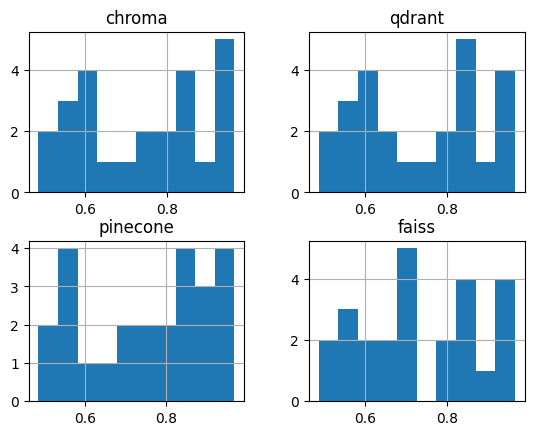

In [94]:
plt.figure(figsize=(10, 5))
google_df.hist()
plt.show()

<Figure size 1000x500 with 0 Axes>

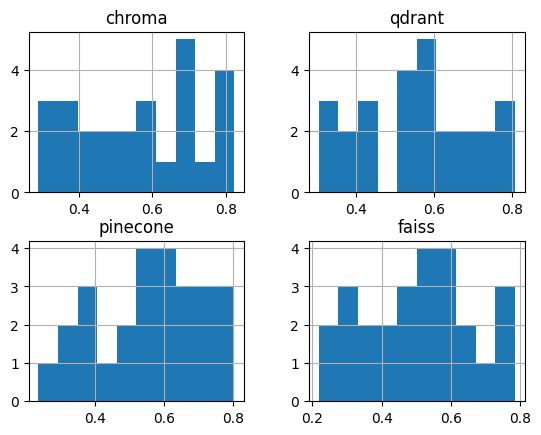

In [95]:
plt.figure(figsize=(10, 5))
openai_df.hist()
plt.show()